# Sequence Tagging: Bidirectional LSTM + CNN

Source: https://github.com/FanhuaandLuomu/BiLstm_CNN_CRF_CWS/blob/master/bilstm_cnn_crf.py

In [1]:
import glob, os, csv, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# AUTO-LABELLED DATA SET = TRAIN SET + VALIDATION SET
filename = r"../1-2 OzROCK/Files/OzROCK dataset/BIG_set_byDictionary.txt"
words = []
tags = []
train_sentences = []

with open(filename, 'r') as file :
    currSentence = []
    lines = []
    for line in file:
        cols = line.split(" ") # should be lower-case already
        if line.strip() == '':
            # Reset sentence            
            train_sentences.append(currSentence)
            currSentence = []
        elif len(cols) > 2:
            print(line)
        else:
            currSentence.append([cols[0].strip(), cols[1].strip()])
            words.append(cols[0].strip())
            tags.append(cols[1].strip())
print('Num sentences = ', len(train_sentences)) # 18589; 160,343

train_words = list(set(words))
print('Num words in training set = ', len(train_words))

train_sent_lengths = [len(s) for s in train_sentences]

plt.hist(train_sent_lengths, density=1, bins=1000) # x value is bins
plt.axis([0, 140, 0, 0.1])  # xmin,xmax,ymin,ymax
plt.xlabel('Sentence Length')
plt.ylabel('Percentage of sentences')

plt.show()

Num sentences =  31813
Num words in training set =  24819


<Figure size 640x480 with 1 Axes>

Num lines =  53295
Num test_sentences =  2000
Num test_words =  4910
13


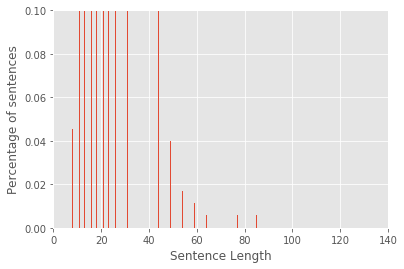

In [2]:
# TEST DATA - manually annotated
file_in = r"../1-2 OzROCK/Files/OzROCK dataset/EvaluationSet_annotated_by_doman_experts.txt" # TestSet_March02
filename_result = r"../1-2 OzROCK/Files/OzROCK dataset/EvaluationSet_trueTag_modelTag.txt" # Evaluation set (expert-annotated) (predicted)

#test_data = pd.read_csv(filename, header = None, delimiter=" ", na_values=['\n'], quoting=csv.QUOTE_NONE, encoding='latin1', skip_blank_lines=True)
#print(test_data.info())
#print(test_data.head(10))
test_words = []
test_sentences = []
c = 0
with open(file_in, 'r') as file :
    currSentence = []
    lines = []
    file.readline()
    for line in file:
        try:
            c += 1
            cols = line.strip().split(" ")
            if line.strip() == '':
                # Reset sentence            
                test_sentences.append(currSentence)
                currSentence = []
            elif len(cols) > 2:
                print('more than 2 columns: ', line)
            else :
                currSentence.append([cols[0].lower().strip(), cols[1].strip()])            
                test_words.append(cols[0].lower().strip())
        except:
            print('error: ', c, line)

test_words = list(set(test_words))
print('Num lines = ', c)
print('Num test_sentences = ', len(test_sentences)) # 18589; 160,343
print('Num test_words = ', len(test_words))
"""
with open(file_in, 'r') as f:
    test_sentences = f.readlines()
    test_sentences = [x.strip() for x in test_sentences]
print('Num sentences = ', len(test_sentences))
print(test_sentences[0])

for s in test_sentences:
    for w in s.split():
        test_words.append(w.strip())
"""
#words = list(set(test_words + train_words))
#print('Num words in training + test sets = ', len(set(train_words)), len(set(test_words)), len(words))

test_sent_lengths = [len(s) for s in test_sentences]
print(test_sent_lengths[0])

plt.hist(test_sent_lengths, density=1, bins=1000) # x value is bins
plt.axis([0, 140, 0, 0.1])  # xmin,xmax,ymin,ymax
plt.xlabel('Sentence Length')
plt.ylabel('Percentage of sentences')

plt.show()

In [3]:
words.append("ENDPAD")
n_words = len(words) # unique words per file
print("Number of unique words in this file: ", n_words)

tags = list(set(tags))
n_tags = len(tags)
print("Number of unique tags in this file: ", n_tags)

Number of unique words in this file:  874760
Number of unique tags in this file:  13


### To encode the character-level information, we will use character embeddings and a LSTM to encode every word to an vector.
We can use anyything that produces a single vector for a sequence of characters that represent a word. (a max-pooling architecture or a CNN)

Then we feed the vector to another LSTM together with the learned word embedding.

In [4]:
max_len = 100

word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

print(word2idx["gold"]) # id=3818
print(tag2idx["B-MINERAL"]) # id = 9

874537
7


In [5]:
# Map the senctences to a sequence of numbers and then pad the sequence
# We increased the index of the words by one to use zero as a padding value, 
# because we want to use the mask_zero parameter of the embedding layer to ignore inputs with value zero

from keras.preprocessing.sequence import pad_sequences

X = [[word2idx[w[0]] for w in s] for s in train_sentences]

# Pad the sentences
#X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

y = [[tag2idx[w[1]] for w in s] for s in train_sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

Using TensorFlow backend.


In [6]:
words[0] = 'NaN'

#words[:10]
print(X[1])
print(y[1])

[874174 874119 874602 874344 854590 874749 872519 872487 874755 874636
 874637 874759 874759 874759 874759 874759 874759 874759 874759 874759
 874759 874759 874759 874759 874759 874759 874759 874759 874759 874759
 874759 874759 874759 874759 874759 874759 874759 874759 874759 874759
 874759 874759 874759 874759 874759 874759 874759 874759 874759 874759
 874759 874759 874759 874759 874759 874759 874759 874759 874759 874759
 874759 874759 874759 874759 874759 874759 874759 874759 874759 874759
 874759 874759 874759 874759 874759 874759 874759 874759 874759 874759
 874759 874759 874759 874759 874759 874759 874759 874759 874759 874759
 874759 874759 874759 874759 874759 874759 874759 874759 874759 874759]
[11 11 11  7  7 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 

In [7]:
from keras.utils import to_categorical # Converts a class vector (integers) to binary class matrix.

# Converts a class vector (integers) to binary class matrix (each class as a one-hot vector)
y = [to_categorical(i, num_classes=n_tags) for i in y]

print(X[1])
print(y[1])

[874174 874119 874602 874344 854590 874749 872519 872487 874755 874636
 874637 874759 874759 874759 874759 874759 874759 874759 874759 874759
 874759 874759 874759 874759 874759 874759 874759 874759 874759 874759
 874759 874759 874759 874759 874759 874759 874759 874759 874759 874759
 874759 874759 874759 874759 874759 874759 874759 874759 874759 874759
 874759 874759 874759 874759 874759 874759 874759 874759 874759 874759
 874759 874759 874759 874759 874759 874759 874759 874759 874759 874759
 874759 874759 874759 874759 874759 874759 874759 874759 874759 874759
 874759 874759 874759 874759 874759 874759 874759 874759 874759 874759
 874759 874759 874759 874759 874759 874759 874759 874759 874759 874759]
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [8]:
# We split in train and test set.
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

In [9]:
print(X_tr.shape)
print(len(y_tr))
print(X_te.shape)
print(len(y_te))

(25450, 100)
25450
(6363, 100)
6363


In [10]:
import string
chars = [s for s in string.printable]
n_chars = len(chars)
print(n_chars)
#chars

100


In [11]:
#chars = set([w_i for w in words for w_i in w])
print(len(words))

chars2 = []
for w in words:
    #print(w)
    if w is np.nan:
        print("nan found")
        continue
    for w_i in w:
        #print(w_i)
        if w_i is np.nan:
            print("nan found")
            continue
        if (w_i not in chars2):
            chars2.append(w_i)

n_chars2 = len(chars2)
print(n_chars2)
#print(chars2)

print("Diff: ", set(chars) - set(chars2))
print("Diff: ", set(chars2) - set(chars))

874760
72
Diff:  {'M', '\x0b', 'R', 'X', 'H', 'C', 'Z', 'V', 'Y', '\\', 'W', 'U', ' ', 'Q', '\n', '\t', 'L', 'G', 'T', '\x0c', 'I', '\r', 'B', 'F', 'S', 'J', 'O', 'K'}
Diff:  set()


In [12]:
import keras
from keras.layers import *
from keras.models import *
from keras_contrib.layers import CRF

#from keras import backend as K

from keras.utils import plot_model
from keras.utils import np_utils

# input:
# maxlen  char_value_dict_len  class_label_count
def Bilstm_CNN_Crf(maxlen, char_value_dict_len, class_label_count):
    
    word_input = Input(shape=(maxlen,), dtype='int32', name='word_input')
    
    word_emb = Embedding(char_value_dict_len + 2, output_dim=64, input_length=maxlen, name='word_emb')(word_input)
    
    ### word emb - bilstm
    bilstm = Bidirectional(LSTM(100, return_sequences=True))(word_emb)
    bilstm_d = Dropout(0.5)(bilstm)
    bilstm_td = TimeDistributed(Dense(100, activation="relu"))(bilstm_d)

    ### character emb - cnn
    half_window_size=1
    padding_layer=ZeroPadding1D(padding=half_window_size)(word_emb)
    
    conv=Conv1D(nb_filter=64, filter_length=2*half_window_size+1, padding='valid')(padding_layer)
    conv_d=Dropout(0.1)(conv)
    dense_conv=TimeDistributed(Dense(64))(conv_d)

    #char_input = Input(shape=(maxCharSize * max_words,), dtype='int32', name='char_input')
    #char_emb = Embedding(char_vocab_size, char_embedding_dim, input_length=max_words*maxCharSize, dropout=dropout, name='char_emb')(char_input)
    #char_cnn = Convolution1D(nb_filter=nb_filters,filter_length= window_length, activation='tanh', border_mode='full') (char_emb) 
    #char_max_pooling = MaxPooling1D(pool_length=maxCharSize) (char_cnn) #  get output per word. this is the size of the hidden layer

    ### MERGE 
    #rnn_cnn_merge = merge([bilstm_d,dense_conv],mode='concat',concat_axis=2)
    rnn_cnn_merge = concatenate([bilstm_td,dense_conv], axis = 2)
    
    #rnn_cnn_merge = merge([bilstm_d, dense_conv], mode='concat', concat_axis=2, name ='rnn_cnn_merge')
    #emb_droput = Dropout(dropout)(total_emb)
    
    ##### ????????????
    #dense=TimeDistributed(Dense(class_label_count))(rnn_cnn_merge)
    dense = TimeDistributed(Dense(82))(rnn_cnn_merge) # 14 classes or half of rnn_cnn_merge = 82 = 164/2

    #dense = TimeDistributed(Dense(50, activation="relu"))(rnn_cnn_merge)  # a dense layer as suggested by neuralNer

    ### CRF
    crf = CRF(class_label_count, sparse_target=False)
    #crf = CRF(class_label_count)  # CRF layer
    crf_output = crf(dense)  # output
    
    # build model
    model = Model(input = [word_input], output = [crf_output])
    #model = Model(input = word_input, output = crf_output)

    #model.compile(loss=crf.loss_function, optimizer='adam', metrics=[crf.accuracy]) # optimizer="rmsprop"
    model.compile(loss=crf.loss_function, optimizer='rmsprop', metrics=[crf.accuracy]) # optimizer="rmsprop"

    #model.summary()
    return model

100 100 13


/Users/majiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(padding="valid", filters=64, kernel_size=3)`
/Users/majiga/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
/Users/majiga/anaconda3/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/majiga/anaconda3/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


(None, 100)
(None, 100, 13)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_input (InputLayer)         (None, 100)          0                                            
__________________________________________________________________________________________________
word_emb (Embedding)            (None, 100, 64)      55984768    word_input[0][0]                 
__________________________________________________________________________________________________
zero_padding1d_1 (ZeroPadding1D (None, 102, 64)      0           word_emb[0][0]                   
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 200)     132000      word_emb[0][0]                   
________________________________________________________________

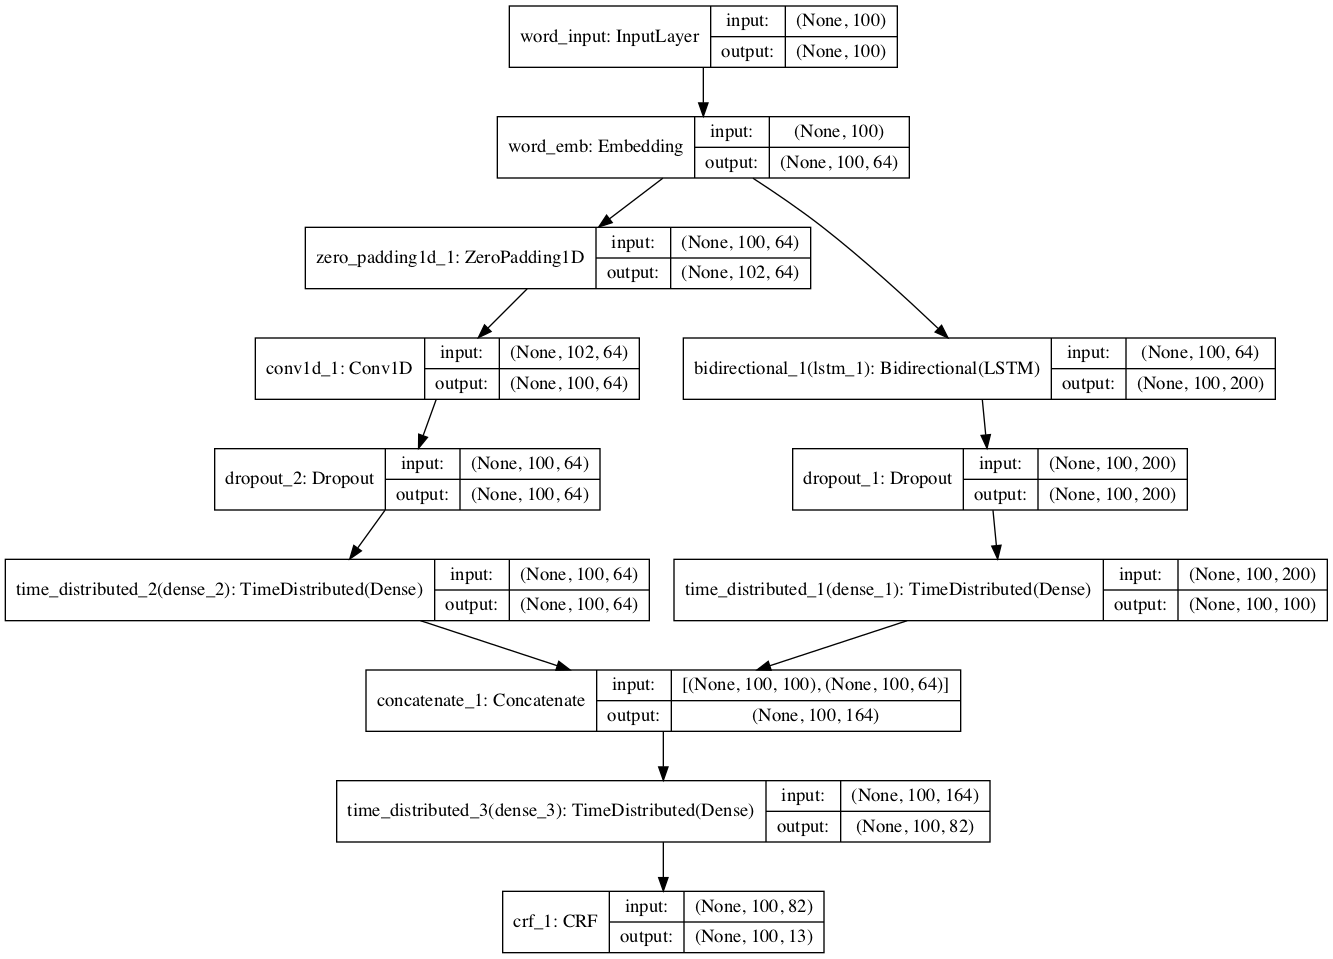

In [13]:
#maxlen,char_value_dict_len,class_label_count=100,1000,4
#char_value_dict_len=100
print(max_len, n_chars, n_tags)
#model=Bilstm_CNN_Crf(max_len, n_chars, n_tags)
model=Bilstm_CNN_Crf(max_len, n_words, n_tags)

print(model.input_shape)
print(model.output_shape)

model.summary()
plot_model(model, to_file='model_CNN.png', show_shapes=True, show_layer_names=True)

In [14]:
history = model.fit(np.array(X_tr), np.array(y_tr), batch_size=32, epochs=40, validation_split=0.2, verbose=2)
#          nb_epoch=20, verbose=2, validation_data=(np.array(X_val),np.array(y_val)), callbacks=[early_stop])

Train on 20360 samples, validate on 5090 samples
Epoch 1/40
 - 615s - loss: 0.0517 - crf_viterbi_accuracy: 0.9870 - val_loss: 0.0086 - val_crf_viterbi_accuracy: 0.9968
Epoch 2/40
 - 1057s - loss: 0.0026 - crf_viterbi_accuracy: 0.9975 - val_loss: -1.5546e-03 - val_crf_viterbi_accuracy: 0.9978
Epoch 3/40
 - 1027s - loss: -6.7385e-03 - crf_viterbi_accuracy: 0.9983 - val_loss: -8.6644e-03 - val_crf_viterbi_accuracy: 0.9979
Epoch 4/40
 - 1036s - loss: -1.4278e-02 - crf_viterbi_accuracy: 0.9986 - val_loss: -1.6178e-02 - val_crf_viterbi_accuracy: 0.9982
Epoch 5/40
 - 844s - loss: -2.1485e-02 - crf_viterbi_accuracy: 0.9989 - val_loss: -2.2454e-02 - val_crf_viterbi_accuracy: 0.9982
Epoch 6/40
 - 751s - loss: -2.8425e-02 - crf_viterbi_accuracy: 0.9991 - val_loss: -2.9340e-02 - val_crf_viterbi_accuracy: 0.9983
Epoch 7/40
 - 739s - loss: -3.5322e-02 - crf_viterbi_accuracy: 0.9993 - val_loss: -3.5450e-02 - val_crf_viterbi_accuracy: 0.9983
Epoch 8/40
 - 729s - loss: -4.1924e-02 - crf_viterbi_accurac

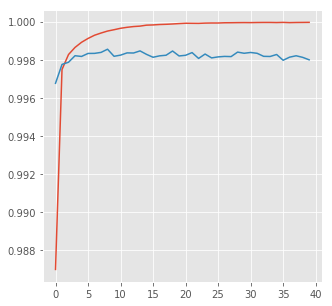

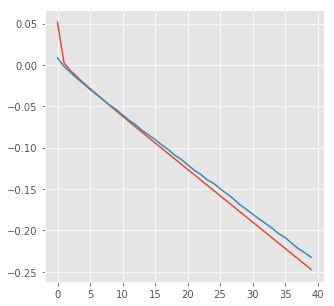

In [15]:
hist = pd.DataFrame(history.history)

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(5,5))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])

plt.figure(figsize=(5,5))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

In [16]:
#### Get the prediction on the test dataset

test_pred=model.predict(X_te, verbose=1)
#print(test_y_pred)
#print(np.argmax(test_y_pred,axis=2))

#K.clear_session()

6363/6363 [==============================] - 15s 2ms/step


In [17]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

print(classification_report(test_labels, pred_labels, digits=4))

F1-score: 96.0%
             precision    recall  f1-score   support

      STRAT     0.9059    0.9417    0.9234      1063
       ROCK     0.9477    0.9712    0.9593      4998
   LOCATION     0.9267    0.9732    0.9494      3843
  TIMESCALE     0.9877    0.9982    0.9929       563
    MINERAL     0.9754    0.9860    0.9807      4139
ORE_DEPOSIT     0.8741    0.9713    0.9201       593

avg / total     0.9456    0.9747    0.9598     15199



In [31]:
from keras.models import load_model

#model.load_weights('CNN_model.weights')
#mCallBack = Callback()
#model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=10, callbacks=[mCallBack])
#model.save_weights('CNN_model.weights')

model.save(r'/Users/majiga/Documents/wamex/data/wamex_model_CNN.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = load_model(r'/Users/majiga/Documents/wamex/datawamex_model.h5')

In [30]:
def get_prediction(i):
    sentence_tags = []
    p = model.predict(np.array([X_te[i]]))
    p = np.argmax(p, axis=-1)
    true = np.argmax(y_te[i], -1)
    #print("{:15}||{:12}||{}".format("Word", "True", "Pred"))
    #print(40 * "=")
    for w, t, pred in zip(X_te[i], true, p[0]):
        if w != 0:
            #print("{:15} {:12} {}".format(words[w-1], tags[t], tags[pred]))
            sentence_tags.append([words[w-1], tags[t], tags[pred]])
    return sentence_tags

In [22]:
result = []
for i in range(0, len(test_pred)):
    result.append(get_prediction(i))
print(len(result))

3501


In [23]:
result[10]

[['The', 'O', 'O'],
 ['radiometric', 'O', 'O'],
 ['data', 'O', 'O'],
 ['had', 'O', 'O'],
 ['the', 'O', 'O'],
 ['following', 'O', 'O'],
 ['processing', 'O', 'O'],
 ['methods', 'O', 'O'],
 ['applied', 'O', 'O'],
 ['.', 'O', 'O'],
 ['Webbprospect(Geoforce,2009', 'O', 'O'],
 ['Webbprospect(Geoforce,2009', 'O', 'O'],
 ['Webbprospect(Geoforce,2009', 'O', 'O'],
 ['Webbprospect(Geoforce,2009', 'O', 'O'],
 ['Webbprospect(Geoforce,2009', 'O', 'O'],
 ['Webbprospect(Geoforce,2009', 'O', 'O'],
 ['Webbprospect(Geoforce,2009', 'O', 'O'],
 ['Webbprospect(Geoforce,2009', 'O', 'O'],
 ['Webbprospect(Geoforce,2009', 'O', 'O'],
 ['Webbprospect(Geoforce,2009', 'O', 'O'],
 ['Webbprospect(Geoforce,2009', 'O', 'O'],
 ['Webbprospect(Geoforce,2009', 'O', 'O'],
 ['Webbprospect(Geoforce,2009', 'O', 'O'],
 ['Webbprospect(Geoforce,2009', 'O', 'O'],
 ['Webbprospect(Geoforce,2009', 'O', 'O'],
 ['Webbprospect(Geoforce,2009', 'O', 'O'],
 ['Webbprospect(Geoforce,2009', 'O', 'O'],
 ['Webbprospect(Geoforce,2009', 'O', 'O']

In [24]:
result_tag_found = []
for r in result:
    for w, t, p in r:
        if t == "O" and t is not p:
            result_tag_found.append(r)
            break
        if t is not "O" and p is not "O" and t is not p:
            result_tag_found.append(r)
            break
print(len(result_tag_found))

178


In [25]:
result_tag_found[0]

[['It', 'O', 'O'],
 ['was', 'O', 'O'],
 ['concluded', 'O', 'O'],
 ['that', 'O', 'O'],
 ['the', 'O', 'O'],
 ['calcretes', 'O', 'O'],
 ['deposits', 'B-GEO_TERM', 'B-GEO_TERM'],
 ['occurring', 'O', 'O'],
 ['within', 'O', 'O'],
 ['the', 'O', 'O'],
 ['tenement', 'O', 'O'],
 ['are', 'O', 'O'],
 ['geomorphologically', 'O', 'O'],
 ['similar', 'O', 'O'],
 ['to', 'O', 'O'],
 ['those', 'O', 'O'],
 ['that', 'O', 'O'],
 ['host', 'O', 'O'],
 ['uranium', 'B-COMMODITY', 'B-COMMODITY'],
 ['deposits', 'B-GEO_TERM', 'B-GEO_TERM'],
 ['elsewhere', 'O', 'O'],
 ['in', 'O', 'O'],
 ['the', 'O', 'O'],
 ['northern', 'O', 'O'],
 ['Yilgarn', 'O', 'B-WA_LOC'],
 ['region', 'O', 'O'],
 [',', 'O', 'O'],
 ['including', 'O', 'O'],
 ['Lake', 'O', 'O'],
 ['Austin', 'B-WA_LOC', 'B-WA_LOC'],
 ['and', 'O', 'O'],
 ['Lake', 'O', 'O'],
 ['Way', 'O', 'O'],
 ['and', 'O', 'O'],
 ['Lake', 'O', 'O'],
 ['Maitland', 'O', 'O'],
 ['.', 'O', 'O'],
 ['Webbprospect(Geoforce,2009', 'O', 'O'],
 ['Webbprospect(Geoforce,2009', 'O', 'O'],
 ['We

In [28]:
import csv

out = csv.writer(open(r"/Users/majiga/Documents/wamex/data/tagged_sentences_CNN.csv","w"), delimiter=',',quoting=csv.QUOTE_ALL)
#out = csv.writer(open(r"C:/wamex/data/tagged_sentences_CNN.csv","w", newline=''), delimiter=',',quoting=csv.QUOTE_ALL)
out.writerow(['Word', 'DictionaryTag', "PredictionTag"])
for r in result_tag_found:
    for w, t, p in r:
        out.writerow([w, t, p])
        if w == ".":
            out.writerow('')
            break

#with open(r"/Users/majiga/Documents/wamex/data/tagged_sentences.csv", w) as f:
print("DONE")

DONE
